# Tutorial 1: Calculating NDVI Spectral Index

In this tutorial, we'll learn how to use GDAL Python API and rasterio module to calculate NDVI and visualize the output results. NDVI is an index calculated from visible red and near infrared wavelengths. This index is used to calculate plant health and identify the condition of vegetated agricultural areas. 

First, we'll start by importing some essential modules such as gdal, numpy and os.
In order to setup GDAL for your Python environment, it is recommended to use Conda to install gdal and its dependencies. 

In [1]:
import gdal
import numpy as np
import os

### Define a function that returns a numpy array and raster properties from an input raster

In [2]:
def raster2nparray(input_ras):
    """
    :param input_ras: Input Raster
    :return: NumPy array from a Raster; single or multi-band
    and other raster properties such as originX, originY, cellSize, spatial reference & NoDataValue
    """
    # Open the input DEM data and get properties
    raster_obj = gdal.Open(input_ras)
    geotransform = raster_obj.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    cellsize = geotransform[1]
    spatialref = raster_obj.GetSpatialRef()

    num_bands = raster_obj.RasterCount
    num_cols = raster_obj.RasterXSize
    num_rows = raster_obj.RasterYSize

    nparray = np.empty([num_bands, num_rows, num_cols])
    ndvals = []

    # Get all bands
    for band in range(num_bands):
        raster_band = raster_obj.GetRasterBand(band+1)
        # Read cells as a numpy array
        nparray[band,:,:] = raster_band.ReadAsArray()
        # Get the NoData value
        ndvals.append(raster_band.GetNoDataValue())

    return nparray, originX, originY, cellsize, spatialref, ndvals

### Define a function that creates an output raster at a specified path from an input numpy array and raster properties.

In [3]:
def nparray2ras(nparray, outRasterPath, cellSize, rasterOrigin, spRef, ndVals):
    """

    :param nparray: Input NumPy Array
    :param outRasterPath: Output raster Path
    :param cellSize: Output raster cell size
    :param rasterOrigin: Output raster origin as a list with [X, Y] coord values
    :param spRef: Output raster spatial reference
    :return: None
    """

    #start creating the output raster and write to it
    gdalDriver = gdal.GetDriverByName('GTiff')
    output_raster = gdalDriver.Create(outRasterPath, nparray.shape[2], nparray.shape[1], nparray.shape[0], gdal.GDT_Float32)
    output_raster.SetGeoTransform((rasterOrigin[0], cellSize, 0, rasterOrigin[1], 0, -cellSize))
    for band in range(output_raster.RasterCount):
        output_band = output_raster.GetRasterBand(band+1)
        output_band.WriteArray(nparray[band, :, :])
        output_band.SetNoDataValue(ndVals[band])
    output_raster.SetProjection(spRef.ExportToWkt())
    output_raster.FlushCache()


### Define a function that takes an input raster and computes NDVI index, saving it to an output raster path

This function calls both the functions 'raster2nparray' and 'nparray2ras' defined above.
The input raster is expected to have a red and near infrared band as the first and fourth bands respectively.

In [4]:
def create_ndvi(input_raster, output_raster):
    """
    :param input_raster: Path to input raster dataset
    :param output_raster Path to output NDVI raster dataset
    :return: None
    """

    nparray, originX, originY, cellSize, spatialRef, ndVals = raster2nparray(input_raster)

    red = nparray[0, :, :]
    nir = nparray[3, :, :]
    red = np.ma.masked_where(nir+red == 0, red)
    ndvi = np.empty([1, nparray.shape[1], nparray.shape[2]])
    ndvi[0,:,:] = (nir - red) / (nir + red)
    nparray2ras(ndvi, output_raster, cellSize, [originX, originY], spatialRef, [-99])

#### Plot the input dataset

We'll use an image acquired from National Agriculture Imagery Program (NAIP). This is a multiband raster which has the bands (red, NIR) required to calculate NDVI index.

##### Data citation Information:
        Originator: USDA-FSA-APFO Aerial Photography Field Office
        Publication_Date: 20131121
        Title: NAIP Digital Ortho Photo Image
        Geospatial_Data_Presentation_Form: remote-sensing image

In [5]:
input_file = os.path.join(
        os.getcwd(), 
        r'Data/m_3910505_nw_13_1_20130926/crop/m_3910505_nw_13_1_20130926_crop.tif'
    )

Now, let us import the 'rasterio' and 'matplotlib' modules that can be used to visualize the input and output datasets.

In [6]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

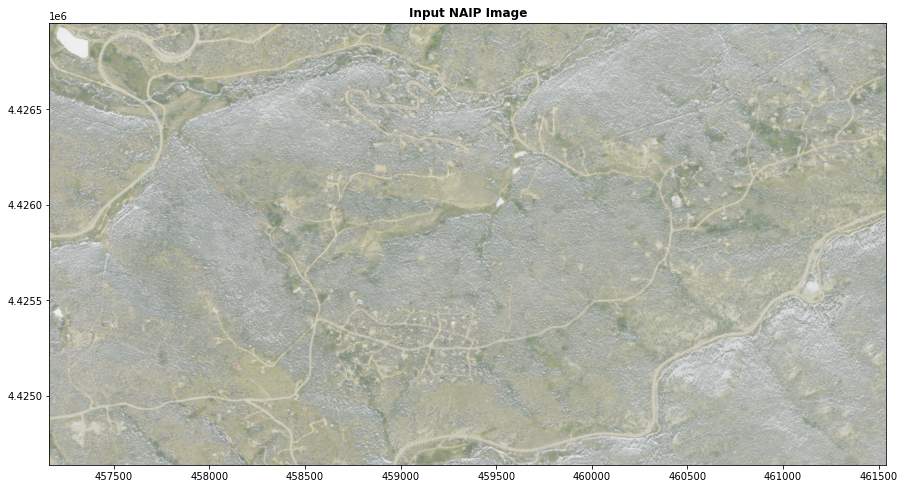

In [7]:
input_src = rasterio.open(input_file)
plt.figure(figsize=(15,15))
show(input_src.read(), transform=input_src.transform, title = "Input NAIP Image")
plt.show()

### Compute NDVI

Now that we've defined various functions to help us read the input raster and oncvert it to numpy arrays, compute NDVI and save the output to a raster dataset, let us call the 'create_ndvi' function to create an NDVI raster. 

In [8]:
outras_file = os.path.join(os.getcwd(), r'Data/Outputs/NDVI_raster.tif')
create_ndvi(input_file, outras_file)

### Visualize the output NDVI raster

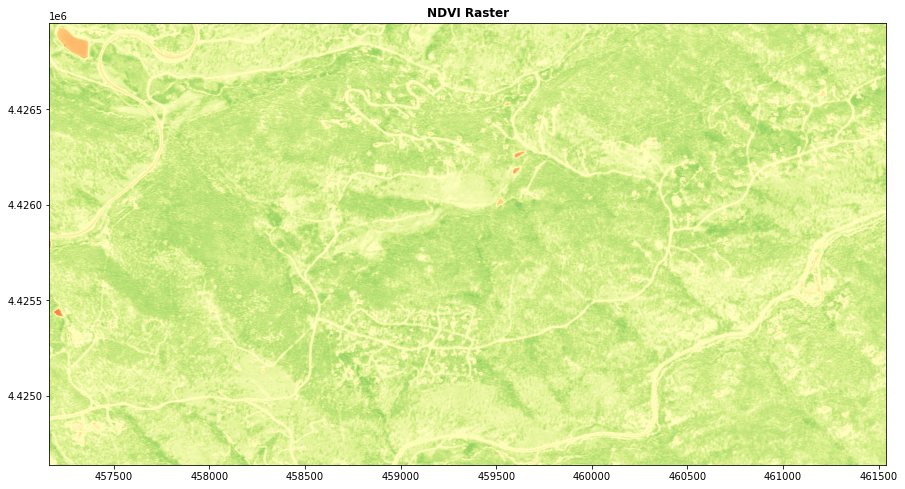

In [9]:
src = rasterio.open(outras_file)

plt.figure(figsize=(15,15))
show(src, cmap = 'RdYlGn', transform=src.transform, title = "NDVI Raster")
plt.show()